# CP 4 Aprendizaje de Máquinas
---

## Regresión Logística

En esta clase práctica, seguiremos usando el dataset de _Rotten Tomatoes_ para clasificar críticas positivas y negativas. Como en las clases anteriores, extraemos el contenido de los archivos.

In [22]:
from pathlib import Path

path_p = Path("txt_sentoken/pos")
path_n = Path("txt_sentoken/neg")

ds_p = list(path_p.iterdir())     # directorio donde están las críticas positivas
ds_n = list(path_n.iterdir())     # directorio donde están las críticas negativas

def convert_file_to_text(file_path: Path) -> str:
    with open(file_path) as f:
        return ''.join(f.readlines())
    
texts_p = [convert_file_to_text(file) for file in ds_p]    # Lista de críticas positivas
texts_n = [convert_file_to_text(file) for file in ds_n]    # Lista de críticas negativas

### Ejercicio 1: Regresión Logística aplicado al dataset de _Rotten Tomatoes_

Apliquemos el algoritmo visto en conferencia, Regresión Logística, para la clasificación de las críticas de _Rotten Tomatoes_. Comenzamos usando, como siempre, `CountVectorizer` para obtener una representación de bolsas de palabras en el dataset.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer 

cv = CountVectorizer()
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()

y = [1]*1000 + [0]*1000

Comprobamos el tamaño del vector de características:

In [24]:
X.shape

(2000, 39659)

Dividimos la matriz de características y el vector de clase en conjuntos de entrenamiento y de prueba, usando el 70% del dataset para entrenamiento. Esta vez, se usa el parámetro `random_state` para obtener la misma división en llamadas sucesivas.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=23)

Usemos ahora el clasificador `LogisticRegression` para realizar el entrenamiento y predicción del dataset en cuestión. El parámetro `solver` de `LogisticRegression` especifica el algoritmo de optimización a usar durante el entrenamiento. En caso que sea requerido, usar uno más sencillo como `liblinear` en vez del que tiene por defecto `sklearn` puede simplificar el proceso de entrenamiento.

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.83

### Ejercicio 2: Visualizando la Matriz de Confusión

En el siguiente ejercicio, visualicemos la matriz de confusión, que especifica de los ejemplos negativos y positivos, cuáles fueron correctamente clasificados como negativos y positivos.

In [28]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

/home/dayany/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


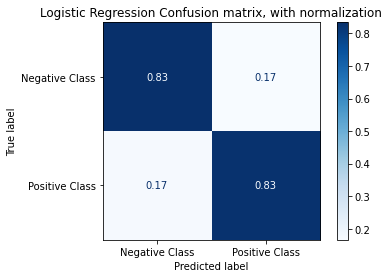

In [29]:
disp = plot_confusion_matrix(lr_model, X_test, y_test,
                             display_labels=['Negative Class', 'Positive Class'],
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

### Ejercicio 3: Probando la clasificación de un texto en específico

Ahora, mostramos cómo se podría realizar la clasificación de un ejemplo específico, para ellos, comprobemos el orden en que las clases son mostradas mediante la propiedad `classes_` de la instancia de `LogisticRegression`.

In [30]:
lr_model.classes_

array([0, 1])

Para probar el clasificador en un ejemplo específico, se debe primero vectorizar la oración de entrada, llamando el método `transform` _vectorizer_, que recibe una lista de _strings_. Luego, el método `predict` recibe la matriz de características y retorna un `array` con las clases clasificadas. El método `predict_proba` da más información, mostrando las probabilidades de pertenencia de cada clase, de acuerdo al orden mostrado de las clases en el método anterior.

Probemos un ejemplo interesante, '*The movie was not fun to watch*', que a pesar de presentar una palabra que podría considerarse positiva ('*fun*', esta se encuentra negada y es en realidad una crítica negativa.

In [31]:
test_review = cv.transform(["The movie was not fun to watch"])
lr_model.predict_proba(test_review)

array([[0.50590186, 0.49409814]])

### Ejercicio 4: Vizualizando las Características más Importantes

Ahora, visualicemos las características más importantes, es decir, las palabras más importantes para clasificar una crítica como negativa o positiva.

In [32]:
import numpy as np
import seaborn as sns

Para ello, tenemos que usar la propiedad de `Logistic Regression` de sklearn, `coef_`, que cuando el problema es binario nos brinda un `ndarray` de dimensión `(1,n_features)` que contiene los coeficiente de las características que resultan del entrenamiento.

Luego, se crea `sorted_idx`, que contiene el índice de las características (palabras) que ordenarían el array según su importancia (de menor a mayor).

In [34]:
feature_importance = lr_model.coef_[0]
sorted_idx = np.argsort(feature_importance)

array([[-2.56240686e-03, -6.15631756e-02,  4.59348918e-05, ...,
        -1.14029799e-02,  0.00000000e+00, -1.32599979e-03]])

El método auxiliar, `get_word`, dado el índice resultante de `sorted_idx`, retorna la palabra que le corresponde a dicho índice.

In [13]:
def get_word(cv: CountVectorizer, w_idx: int) -> str:
    "Given the index of a word, finds in the vocabulary of the CountVectorizer the word"
    return list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w_idx)]

Obtengamos entonces el orden de las palabras más importantes para clasificar una crítica como positiva. Notar que las características positivas son aquellas que tienen un mayor coeficiente.

In [14]:
top_10_pos_w = [get_word(cv, w) for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['fun', 'quite', 'back', 'great', 'see', 'ben', 'well', 'seen', 'performance', 'always']


Ahora obtengamos la importancia de las características (usando el _array_ `feature_importance`)

In [15]:
top_10_pos_importance = feature_importance[sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_importance)

[0.54422013 0.39439874 0.37513935 0.36671324 0.35290454 0.3401429
 0.33351279 0.32880539 0.32798958 0.32156777]


La función `plot_importance` recibe una lista de palabras importantes y su importancia, y muestra en un gráfico de barras dichas palabras.

In [16]:
def plot_importance(top10_w, top_10_impo):
    'Función auxiliar que, dado las grafica las palabras más importantes y su importancia'
    fig = plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=top10_w, y=top_10_impo)
    _, x_labels = plt.xticks()
    plt.setp(x_labels, rotation=40)
    plt.ylabel('Feature Importance', fontsize=12)
    plt.xlabel('Word', fontsize = 12);

Grafiquemos las palabras positivas más importantes:

Most Important Words Used for Positive Sentiment


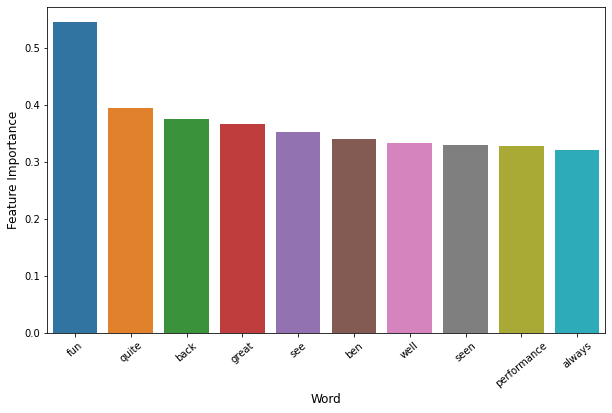

In [17]:
plot_importance(top_10_pos_w, top_10_pos_importance)

Ahora obtengamos las palabras negativas más importantes:

In [19]:
top_10_neg_w = [get_word(cv, w) for w in sorted_idx[:10]]
print(top_10_neg_w)

['bad', 'worst', 'unfortunately', 'looks', 'any', 'nothing', 'boring', 'awful', 'script', 'through']


Y su importancia:

In [20]:
top_10_neg_importance = feature_importance[sorted_idx[:10]]
print(top_10_neg_importance)

[-0.62402099 -0.59591589 -0.55308501 -0.46475953 -0.42456335 -0.41363352
 -0.40823836 -0.39915508 -0.3913603  -0.39125439]


Luego, como hicimos anteriormente, mostremos en una gráfica de barras su importancia.

Most Important Words Used for Negative Sentiment


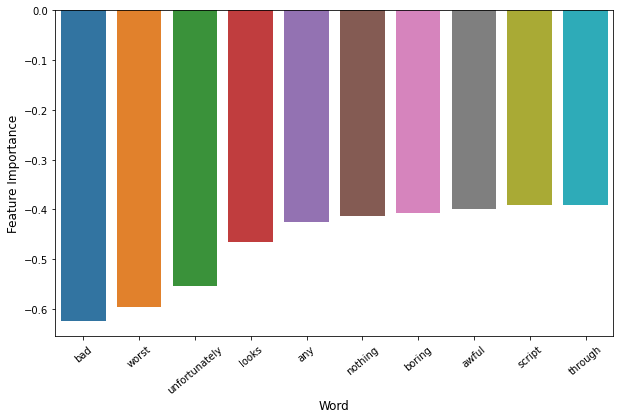

In [21]:
plot_importance(top_10_neg_w, top_10_neg_importance)
print("Most Important Words Used for Negative Sentiment")

### Ejercicio 7: Ideas Para Mejorar: Añadir bigramas

Una idea para mejorar el modelo anterior es añadir bigramas a la clasificación. El vector resultante tiene muchas características, una estrategia válida es disminuir la cantidad de palabras que tiene en cuenta, usando `max_df` para eliminar las palabras más frecuentes, o `min_df` para las menos frecuentes.

In [21]:
cv = CountVectorizer(min_df=2, ngram_range=(1,2))
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()
X.shape

(2000, 139448)

Dividimos de nuevo la nueva matriz de características y el vector de clases en conjuntos de entrenamiento y de prueba.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=23)

Y volvemos a usar el clasificador `LogisticRegression`, para obtener la precisión con esta nueva matriz de características.

In [23]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8483333333333334

Ahora probemos el ejemplo '*The movie was not fun to watch*' visto anteriormente y observemos ahora como (debería) dar más probabilidades de pertenecer a la clase negativa añadiendo bigramas que cuando se usaban solo unigramas.

In [24]:
test_review = cv.transform(["The movie was not fun to watch"])
lr_model.predict_proba(test_review)

array([[0.51134957, 0.48865043]])

### Ejercicio 8: Ideas para Mejorar: Disminuir el umbral de corte de probabilidad

Otra alternativa para la mejora es disminuyendo o aumentando el umbral de corte de probabilidad que usa `LogisticRegression` para clasificar los ejemplos en positivos o negativos.

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score

Usemos la siguiente lista para establecer el umbral de posibles probabilidades:

In [27]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6]

Para ello, predecimos las probabilidades de pertenencia a cada clase que se obtendría en el conjunto de prueba `X_test`, usando el método `predict_proba` del modelo de `LogisticRegression`.

In [26]:
pred_proba_df = pd.DataFrame(lr_model.predict_proba(X_test))

Luego, dado el array de probabilidades, nos quedamos con aquellos valores que tengan una probabilidad mayor que el umbral como ejemplos positivos, y negativos en otro caso. Despues, calculamos la precisión obtenida con estos resultados en dependencia de `y_test`, la respuesta real usando la función `accuracy_score`, que recibe el array de clases real y el array de clases predecida.

In [28]:
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)
    test_accuracy = round(accuracy_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('Accuracy: {}'.format(test_accuracy))


******** For i = 0.4 ******
Accuracy: 0.85

******** For i = 0.45 ******
Accuracy: 0.85

******** For i = 0.5 ******
Accuracy: 0.848

******** For i = 0.55 ******
Accuracy: 0.85

******** For i = 0.6 ******
Accuracy: 0.853
